In [24]:
import torch

import matplotlib.pyplot as plt
import pickle

from enc_dec.utils import plot_tensors
from enc_dec.model import TranslGRU

In [25]:
log_file = './data/train-log.txt'
trained_model = './data/saved_model.pkl'

# Plot loss curve

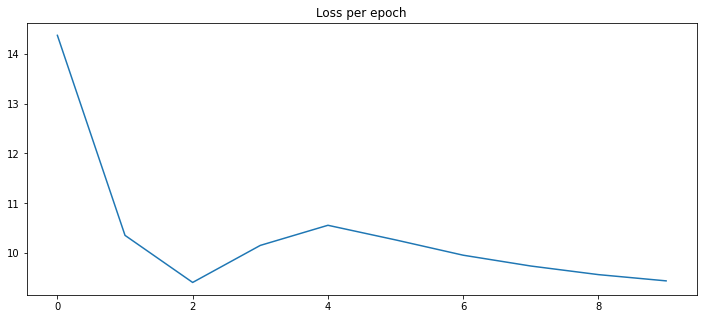

In [26]:
losses = []
with open(log_file, "r") as f:
  for line in f:
    line = line.strip()
    losses.append( float(line.split()[-1]) )

plt.figure(figsize=(12,5))
plt.plot(losses)
plt.title(f"Loss per epoch")
plt.show()

# Inspect gradients or weights

In [27]:
objects = []
with (open(trained_model, "rb")) as f:
    while True:
        try:
            objects.append(pickle.load(f))
        except EOFError:
            break

model_dict = objects[0]

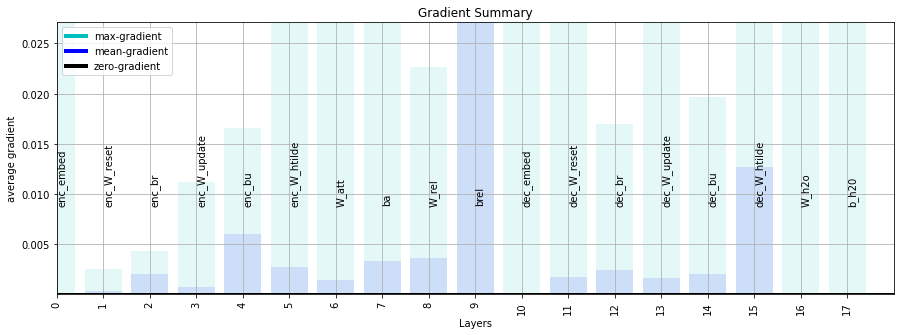

In [28]:
plt.figure(figsize=(15,5))
plot_tensors(model_dict['grads'], param_names=model_dict['names'], y_ax_max="max_average", type="gradient")

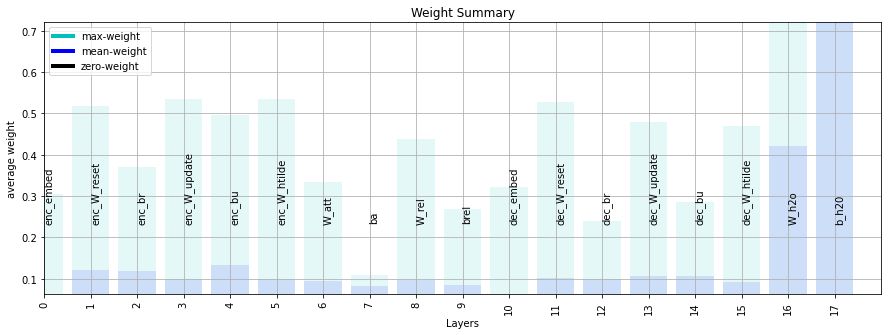

In [29]:
plt.figure(figsize=(15,5))
plot_tensors(model_dict['weights'], param_names=model_dict['names'], y_ax_max="max_average", type="weight")

# Model inference

In [30]:
config = model_dict['config']

In [31]:
model = TranslGRU(vocab_size=config['vocab_size'],
                enc_embed_dim=config['enc_embed_dim'],
                dec_embed_dim=config['dec_embed_dim'],
                dec_type=config['dec_type'],
                hidden_size=config['hidden_size'],
                max_length=config['max_length'],
                stoi_mapping=config['stoi'], 
                start_chr=config['start_chr'], stop_chr=config['stop_chr']
                )

model.restore_weights(model_dict['weights'], device=torch.device('cpu'))

In [42]:
model.evaluate("happy", level="word")

'soyez <'